In [133]:
import numpy as np
from keras.datasets import mnist
import keras
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
plt.gray()
%matplotlib inline

In [225]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., None] / 255.0
x_test = x_test[..., None] / 255.0
ex = x_train[44] #to distort into an 8
ex2 = x_train[1]

Text(0.5,1,'True Class: 3')

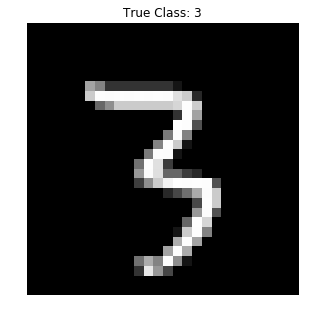

In [270]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.imshow(ex.reshape(28, 28))
plt.axis('off')
plt.title('True Class: 3')

# plt.subplot(1, 2, 2)
# plt.imshow(ex2.reshape(28, 28))
# plt.axis('off')
# plt.title('True Class: 0')

In [115]:
model = keras.models.load_model('./simple_cnn.h5')

In [116]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = K.get_session()
# K.set_learning_phase(0)

In [242]:
target_grad = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0,], dtype=np.float32)[None]
target_2 = np.array([0, 0, 0, -1, 0, 0, 0, 1, 0, 0,], dtype=np.float32)[None]

In [118]:
x = model.input
y = model.output

In [243]:
int_grad = tf.gradients(y, x, target_grad)
diff_grad = tf.gradients(y, x, target_2)

In [238]:
eps = 1e3
ints = []
tmp = ex.copy()[None]
i = 0
while i<2000 and (sess.run(y, feed_dict={x:tmp}).argmax() != 7):
    tmp += eps*sess.run(int_grad, feed_dict={x:tmp})[0]
    if sess.run(y, feed_dict={x:tmp})[0, 7] > 1e-4:
        eps = 1e-1
    tmp = np.clip(tmp, 0, 1)
    i += 1

(-0.5, 27.5, 27.5, -0.5)

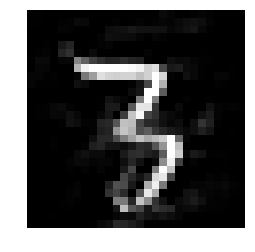

In [239]:
plt.imshow(tmp[0, ..., 0])
plt.axis('off')

In [240]:
np.round(sess.run(y, feed_dict={x:tmp})[0], 3)

array([0.  , 0.  , 0.  , 0.44, 0.  , 0.  , 0.  , 0.56, 0.  , 0.  ],
      dtype=float32)

In [249]:
tmp

(22, 12)

In [266]:
eps = 1e3
ints = []
tmp = ex.copy()[None]
i = 0
while i<20 and (sess.run(y, feed_dict={x:tmp}).argmax() != 7):
    ps = sess.run(int_grad, feed_dict={x:tmp})[0] * (tmp!=1)
    ixx = np.unravel_index(ps.argmax(), (28, 28))
    tmp[:, ixx[0], ixx[1]] = 1.0
#     if sess.run(y, feed_dict={x:tmp})[0, 7] > 1e-4:
#         eps = 1e-1
#     tmp = np.clip(tmp, 0, 1)
    i += 1

(-0.5, 27.5, 27.5, -0.5)

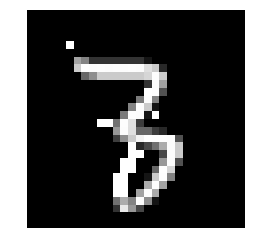

In [267]:
plt.imshow(tmp[0, ..., 0])
plt.axis('off')

In [265]:
np.round(sess.run(y, feed_dict={x:tmp})[0], 3)

array([0.   , 0.   , 0.002, 0.411, 0.   , 0.   , 0.   , 0.566, 0.022,
       0.   ], dtype=float32)